<a href="https://colab.research.google.com/github/dfdrv/RoadDamage/blob/main/RoadDamage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Детектирование дефектов дорожного полотна

**О наборе данных **

Этот набор данных создан для обучения моделей глубокого обучения. Все изображения были сделаны с помощью камеры смартфона (Xiaomi Redmi Note 8) с разрешением около 1080p.

Набор данных состоит из двух типов данных: изображения и аннотации, которые всегда находятся в паре. Аннотации пишутся в стиле YOLOv3, каждая строка представляет собой одну истину в формате аннотации.

https://www.kaggle.com/datasets/alvarobasily/road-damage/

## Загрузка данных

Для загрузки датасета из Kaggle в Google Colab выполните следующие шаги:

1. Зайдите на сайт Kaggle, войдите в свой аккаунт.
2. Перейдите в настройки: кликните на ваш аватар → Account.
3. В разделе API нажмите кнопку Create New API Token.
4. Скачайте файл kaggle.json — это ваш API токен.

Загрузите файл kaggle.json

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pelivan","key":"1e7c2bbc50f8b24731228247b3555020"}'}

Переместите файл kaggle.json в правильное место и установите права доступа:

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Убедимся, что Kaggle API установлен:

In [ ]:
!pip install -q kaggle

Загружаем набор данных

In [ ]:
!kaggle datasets download -d alvarobasily/road-damage

Dataset URL: https://www.kaggle.com/datasets/alvarobasily/road-damage
License(s): CC0-1.0
 99% 1.63G/1.64G [00:16<00:00, 146MB/s]
100% 1.64G/1.64G [00:16<00:00, 107MB/s]


In [ ]:
!unzip road-damage.zip -d /content/dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/BK_2650.txt  
  inflating: /content/dataset/BK_2670.jpeg  
  inflating: /content/dataset/BK_2670.txt  
  inflating: /content/dataset/BK_2680.jpeg  
  inflating: /content/dataset/BK_2680.txt  
  inflating: /content/dataset/BK_2700.jpeg  
  inflating: /content/dataset/BK_2700.txt  
  inflating: /content/dataset/BK_2710.jpeg  
  inflating: /content/dataset/BK_2710.txt  
  inflating: /content/dataset/BK_3160.jpeg  
  inflating: /content/dataset/BK_3160.txt  
  inflating: /content/dataset/BK_3170.jpeg  
  inflating: /content/dataset/BK_3170.txt  
  inflating: /content/dataset/BK_320.jpeg  
  inflating: /content/dataset/BK_320.txt  
  inflating: /content/dataset/BK_3240.jpeg  
  inflating: /content/dataset/BK_3240.txt  
  inflating: /content/dataset/BK_330.jpeg  
  inflating: /content/dataset/BK_330.txt  
  inflating: /content/dataset/BK_3690.jpeg  
  inflating: /content/dataset/BK_3690.txt  
  

Убедимся, что файлы загружены правильно:

In [ ]:
!ls /content/dataset

A_2890.jpeg    AR_5460.txt    C_3380.jpeg   G_1420.jpeg   P_11950.txt	R_5840.jpeg   X_9740.txt
A_2890.txt     AS_6920.jpeg   C_3380.txt    G_1420.txt	  P_11960.jpeg	R_5840.txt    Y_13560.jpeg
A_3190.jpeg    AS_6920.txt    C_3430.jpeg   G_1560.jpeg   P_11960.txt	R_5850.jpeg   Y_13560.txt
A_3190.txt     AS_6930.jpeg   C_3430.txt    G_1560.txt	  P_11970.jpeg	R_5850.txt    Y_13570.jpeg
A_3200.jpeg    AS_6930.txt    C_3490.jpeg   G_1620.jpeg   P_11970.txt	R_5860.jpeg   Y_13570.txt
A_3200.txt     AS_6940.jpeg   C_3490.txt    G_1620.txt	  P_11980.jpeg	R_5860.txt    Y_13580.jpeg
A_5760.jpeg    AS_6940.txt    C_3510.jpeg   G_1680.jpeg   P_11980.txt	R_5870.jpeg   Y_13580.txt
A_5760.txt     AS_7010.jpeg   C_3510.txt    G_1680.txt	  P_11990.jpeg	R_5870.txt    Y_13590.jpeg
A_6180.jpeg    AS_7010.txt    C_3560.jpeg   G_1730.jpeg   P_11990.txt	R_5880.jpeg   Y_13590.txt
A_6180.txt     AS_7020.jpeg   C_3560.txt    G_1730.txt	  P_12000.jpeg	R_5880.txt    Y_13600.jpeg
A_8360.jpeg    AS_7020.txt    C_3610

Импорт библиотек

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from shutil import copy2
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torchvision.utils as vutils

In [ ]:
data_path = "/content/dataset"

In [ ]:
# Получаем список всех файлов в папке
all_files = sorted(os.listdir(data_path))

# Фильтруем изображения и аннотации
images = [f for f in all_files if f.endswith('.jpeg')]
annotations = [f for f in all_files if f.endswith('.txt')]

# Проверяем, что пары соответствуют
pairs = list(zip(images, annotations))
print(f"Найдено {len(pairs)} пар изображений и аннотаций.")

Найдено 3321 пар изображений и аннотаций.


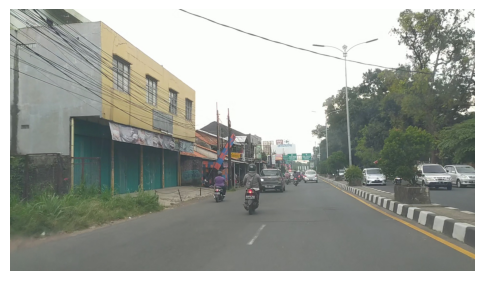

Аннотация к изображению:
2 0.589323 0.810648 0.155729 0.008333



In [ ]:
# Берем первый элемент из списка пар
first_image, first_annotation = pairs[0]

# Загружаем изображение
image_path = os.path.join(data_path, first_image)
image = Image.open(image_path)

# Считываем аннотацию
annotation_path = os.path.join(data_path, first_annotation)
with open(annotation_path, 'r') as f:
    annotation_data = f.read()

# Вывод изображения и аннотации
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

print("Аннотация к изображению:")
print(annotation_data)

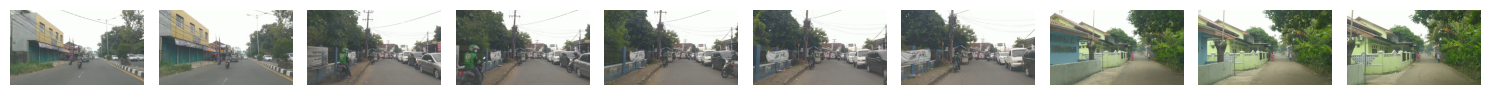

In [ ]:
# Количество изображений для отображения
n_images_to_show = 10
pairs_to_show = pairs[:n_images_to_show]

# Вывод изображений и аннотаций
plt.figure(figsize=(15, 15))
for i, (image_name, annotation_name) in enumerate(pairs_to_show):
    # Загружаем изображение
    image_path = os.path.join(data_path, image_name)
    image = Image.open(image_path)

    # Считываем аннотацию
    annotation_path = os.path.join(data_path, annotation_name)
    with open(annotation_path, 'r') as f:
        annotation_data = f.read()

    # Отображаем изображение
    plt.subplot(1, n_images_to_show, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Проверка корректности аннотаций

Bounding boxes должны находиться внутри границ изображения

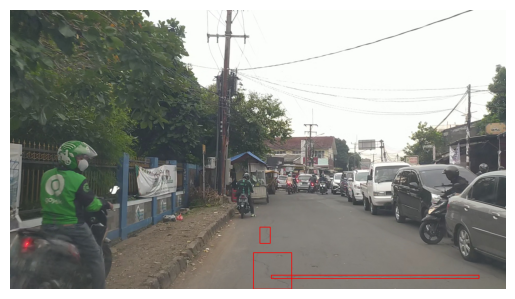

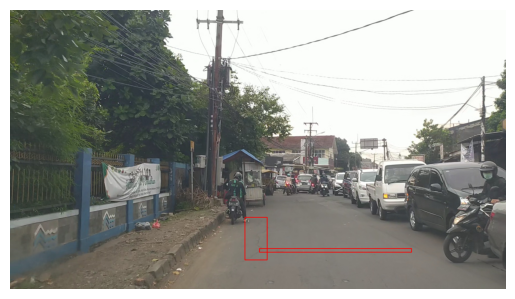

In [ ]:
def draw_bounding_boxes(image_path, annotation_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Загрузка аннотации
    with open(annotation_path, 'r') as f:
        annotations = f.readlines()

    h, w, _ = image.shape
    for ann in annotations:
        class_id, x_center, y_center, box_width, box_height = map(float, ann.split())
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)
        # Рисуем прямоугольник
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Отображаем изображение
    plt.imshow(image)
    plt.axis('off')
    plt.show()

draw_bounding_boxes('/content/dataset/AB_1010.jpeg', '/content/dataset/AB_1010.txt')
draw_bounding_boxes('/content/dataset/AB_1020.jpeg', '/content/dataset/AB_1020.txt')

Убедимся, что нет пустых аннотаций

In [ ]:
def count_empty_annotations(data_path):
    empty_count = 0
    all_files = sorted(os.listdir(data_path))

    # Фильтруем файлы с аннотациями
    annotation_files = [f for f in all_files if f.endswith('.txt')]

    for annotation_file in annotation_files:
        annotation_path = os.path.join(data_path, annotation_file)

        # Открываем файл аннотации и читаем его
        with open(annotation_path, 'r') as file:
            lines = file.readlines()

            # Если файл пустой или не содержит строк с аннотациями
            if not lines:
                empty_count += 1
            else:
                # Проверяем, есть ли строки с аннотациями (т.е. строки с информацией)
                if all(line.strip() == "" for line in lines):
                    empty_count += 1

    return empty_count

# Путь к папке с данными
data_path = "/content/dataset"  # Замените на путь к вашему датасету

empty_annotations = count_empty_annotations(data_path)
print(f"Количество пустых аннотаций: {empty_annotations}")

Количество пустых аннотаций: 0


## Разделение датасета

Разделим датасет на тренировочный, валидационный и тестовый наборы

In [ ]:
def split_dataset(data_path, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    # Проверка, что сумма долей равна 1
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Сумма долей должна быть равна 1.0")

    # Создаем директории для разделенных данных
    os.makedirs(f"{output_dir}/train", exist_ok=True)
    os.makedirs(f"{output_dir}/val", exist_ok=True)
    os.makedirs(f"{output_dir}/test", exist_ok=True)

    # Получаем список всех изображений
    images = [f.split('.')[0] for f in os.listdir(data_path) if f.endswith('.jpeg')]

    # Перемешиваем список для случайного разделения
    random.shuffle(images)

    # Рассчитываем индексы для разделения
    train_size = int(len(images) * train_ratio)
    val_size = int(len(images) * val_ratio)

    # Разделяем данные
    train_images = images[:train_size]
    val_images = images[train_size:train_size + val_size]
    test_images = images[train_size + val_size:]

    # Копируем изображения и аннотации в соответствующие папки
    for image in train_images:
        copy2(f"{data_path}/{image}.jpeg", f"{output_dir}/train")
        copy2(f"{data_path}/{image}.txt", f"{output_dir}/train")

    for image in val_images:
        copy2(f"{data_path}/{image}.jpeg", f"{output_dir}/val")
        copy2(f"{data_path}/{image}.txt", f"{output_dir}/val")

    for image in test_images:
        copy2(f"{data_path}/{image}.jpeg", f"{output_dir}/test")
        copy2(f"{data_path}/{image}.txt", f"{output_dir}/test")

    print(f"Датасет разделен: {len(train_images)} тренировочных, {len(val_images)} валидационных, {len(test_images)} тестовых изображений.")

# Путь к исходному датасету
data_path = "/content/dataset"

# Путь к директории, куда будут скопированы разделенные данные
output_dir = "/content/split_dataset"

# Разделение датасета
split_dataset(data_path, output_dir)

Датасет разделен: 2324 тренировочных, 498 валидационных, 499 тестовых изображений.


## Подготовка батчей к обучению

Создадим класс, который будет загружать и возвращать изображения с соответствующими аннотациями.

In [ ]:
class RoadDefectDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # Получаем список всех изображений
        self.image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.jpeg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Загружаем изображение
        image_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB")

        # Загружаем аннотацию
        annotation_path = image_path.replace(".jpeg", ".txt")
        with open(annotation_path, "r") as file:
            annotations = file.readlines()

        boxes = []
        labels = []

        # Парсим аннотации в YOLO формате
        for ann in annotations:
            class_id, x_center, y_center, width, height = map(float, ann.split())

            # Преобразуем нормализованные координаты в пиксели
            boxes.append([x_center, y_center, width, height])
            labels.append(class_id)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        # Применяем трансформации, если они есть
        if self.transform:
            image = self.transform(image)

        return image, boxes, labels

Трансформации (Аугментации и нормализация)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((416, 416)),   # Изменение размера изображения
    transforms.ToTensor(),           # Преобразование в Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

После того как создадим датасет, можно использовать DataLoader, чтобы подать данные в модель батчами.

In [ ]:
# Путь к папке с изображениями и аннотациями
data_path = '/content/split_dataset/train'  # Путь к тренировочному набору

# Создаем объект Dataset
dataset = RoadDefectDataset(data_dir=data_path, transform=transform)

# Создаем DataLoader
batch_size = 16  # Размер батча
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Проверим количество батчей
print(f"Количество батчей в датасете: {len(train_loader)}")

Количество батчей в датасете: 146


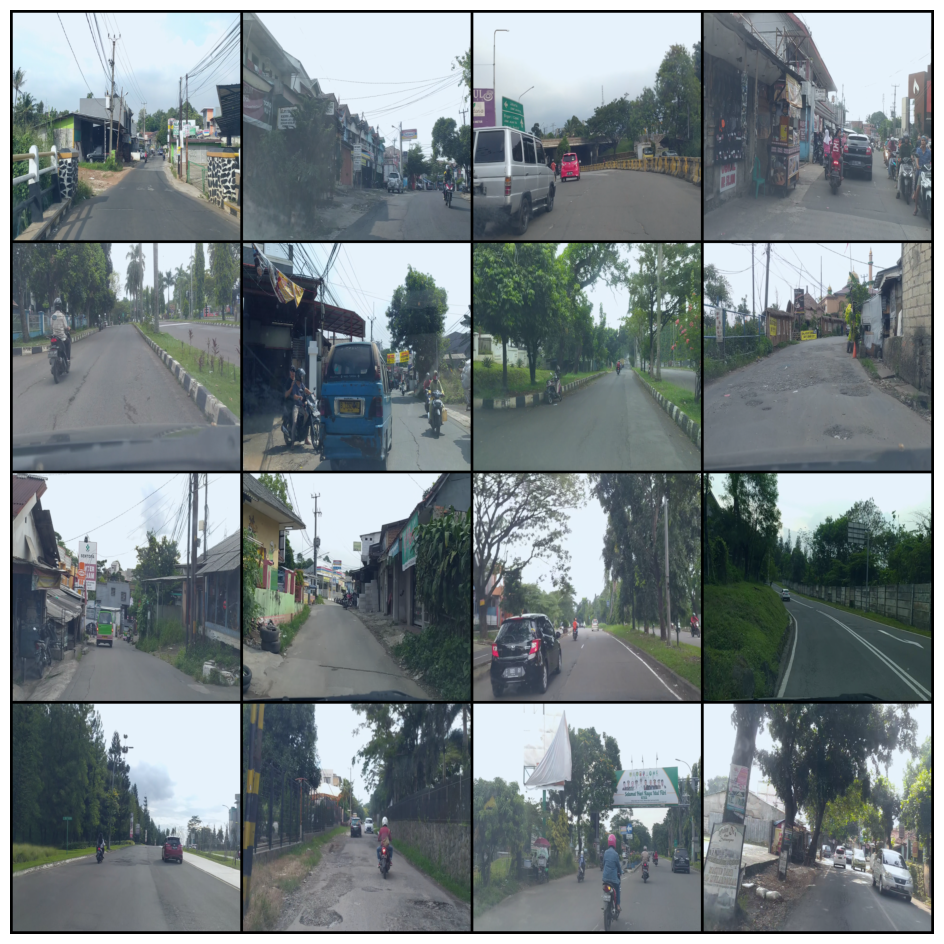

In [ ]:
# Получаем первый батч данных
images, boxes, labels = next(iter(train_loader))

# Изображения в формате tensor, нужно их преобразовать в numpy для отображения
images = torch.stack(images)  # Убедимся, что все изображения в одном тензоре

# Отображаем изображения
grid = vutils.make_grid(images, nrow=4, padding=5, normalize=True)  # Настроим размер сетки (4 изображения в ряду)

# Преобразуем в формат для отображения (из Tensor в numpy)
grid = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 12))
plt.imshow(grid)
plt.axis('off')
plt.show()

## Обучение модели YOLOv7

Установка YOLOv7

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7
!pip install -r requirements.txt

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.23 MiB | 25.04 MiB/s, done.
Resolving deltas: 100% (519/519), done.
/content/yolov7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.8/407.8 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore

Подготовка датасета

In [ ]:
import os

# Путь к папке с разделенными данными
split_data_path = "/content/split_dataset"

# Создаем файлы конфигурации для YOLOv7
with open("data/road_defects.yaml", "w") as f:
    f.write(f"""
    train: {os.path.join(split_data_path, 'train')}
    val: {os.path.join(split_data_path, 'val')}
    test: {os.path.join(split_data_path, 'test')}

    nc: 4  # Количество классов
    names: ['Pothole', 'Alligator Crack', 'Longitudinal Crack', 'Lateral Crack']
    """)


Обучение модели YOLOv7

In [ ]:
!python train.py --img 416 --batch 16 --epochs 50 --data data/road_defects.yaml --cfg cfg/training/yolov7.yaml --weights '' --name road_defects_yolov7

2024-11-27 17:28:00.335781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 17:28:00.355794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 17:28:00.363141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 17:28:00.377907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 17:28:01.407648: W tensorflow/compiler/tf2